
# Tutorial 1: Basic Connectivity Patterns

**Duration:** 15–20 minutes · **Level:** Beginner

In this tutorial you will learn how to:

- Understand the core data structures used by `braintools.conn`
- Build fundamental connectivity patterns (random, all-to-all, one-to-one)
- Inspect `ConnectionResult` objects and derive quick statistics
- Visualize connectivity matrices and simple network topologies
- Combine patterns into small example projects



## Prerequisites

- Python 3.10+
- Familiarity with NumPy arrays
- Optional: basic knowledge of synaptic connectivity terminology


In [1]:

import numpy as np
import brainunit as u
import matplotlib.pyplot as plt

from braintools.conn import ConnectionResult, Random, AllToAll, OneToOne, Ring
from braintools.init import Normal, Uniform, Constant
import braintools.visualize as visualize

plt.rcParams["figure.dpi"] = 110


def make_rng(seed: int) -> np.random.Generator:
    '''Utility helper to create reproducible RNGs.'''
    return np.random.default_rng(seed)


In [2]:
def summarize_result(result: ConnectionResult, label: str) -> None:
    '''Pretty-print summary statistics for a connectivity result.'''
    pre_size, post_size = result.shape
    total_possible = max(pre_size * post_size, 1)
    density = result.n_connections / total_possible

    print(f"{label}")
    print(f"  connections : {result.n_connections:,}")
    print(f"  shape       : {pre_size} × {post_size}")
    print(f"  density     : {density:.3f}")

    if result.metadata:
        pattern = result.metadata.get("pattern")
        if pattern:
            print(f"  pattern     : {pattern}")

    if result.weights is not None:
        mantissa, unit = u.split_mantissa_unit(result.weights)
        w_min = float(np.min(mantissa))
        w_max = float(np.max(mantissa))
        unit_label = f" {unit}" if unit is not None else ""
        print(f"  weight      : [{w_min:.3f}, {w_max:.3f}]{unit_label}")
    else:
        print("  weight      : (implicit 1.0)")

    if result.delays is not None:
        mantissa, unit = u.split_mantissa_unit(result.delays)
        d_min = float(np.min(mantissa))
        d_max = float(np.max(mantissa))
        unit_label = f" {unit}" if unit is not None else ""
        print(f"  delay       : [{d_min:.3f}, {d_max:.3f}]{unit_label}")
    else:
        print("  delay       : (implicit 0.0)")



## Understanding `ConnectionResult`

Every connectivity generator in `braintools.conn` returns a `ConnectionResult`.
It stores presynaptic and postsynaptic indices, optional weights/delays, and
metadata describing how the connections were generated. The helper above will be
used throughout the tutorial to summarise results.



## Basic connectivity patterns

### Random connectivity

Random connectivity connects each presynaptic element to a postsynaptic element
with a fixed probability. Here we also draw weights from a normal distribution
and delays from a uniform distribution.


In [3]:

random_pattern = Random(
    prob=0.12,
    weight=Normal(mean=1.0 * u.nS, std=0.25 * u.nS),
    delay=Uniform(low=0.5 * u.ms, high=2.0 * u.ms),
    allow_self_connections=False,
    seed=42,
)

random_result = random_pattern(pre_size=100, post_size=100)
summarize_result(random_result, "Random connectivity (100 × 100, p = 0.12)")


Random connectivity (100 × 100, p = 0.12)
  connections : 1,216
  shape       : 100 × 100
  density     : 0.122
  pattern     : random
  weight      : [0.041, 1.844] nS
  delay       : [0.500, 1.999] ms


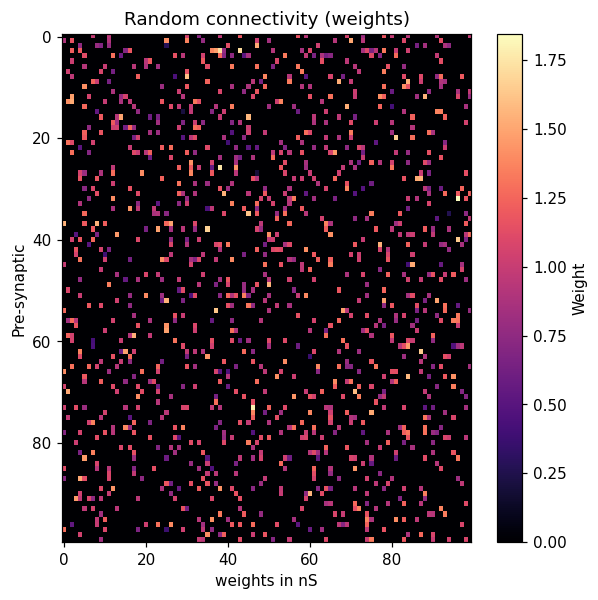

In [4]:

weights_dense, weight_unit = u.split_mantissa_unit(random_result.weight2dense())

fig, ax = plt.subplots(figsize=(6, 6))
visualize.connectivity_matrix(
    weights_dense,
    cmap="magma",
    center_zero=False,
    ax=ax,
    title="Random connectivity (weights)",
)
if weight_unit is not None:
    ax.set_xlabel(f"weights in {weight_unit}")
plt.show()



### All-to-all connectivity

All-to-all connectivity creates a fully connected bipartite graph between a
presynaptic and postsynaptic population. We exclude self-connections for a
strict feedforward layer.


In [5]:

all_to_all_pattern = AllToAll(
    include_self_connections=False,
    weight=Constant(0.5 * u.nS),
    delay=Constant(1.0 * u.ms),
)

all_to_all_result = all_to_all_pattern(pre_size=16, post_size=16)
summarize_result(all_to_all_result, "All-to-all connectivity (16 × 16)")


All-to-all connectivity (16 × 16)
  connections : 240
  shape       : 16 × 16
  density     : 0.938
  pattern     : all_to_all
  weight      : [0.500, 0.500] nS
  delay       : [1.000, 1.000] ms


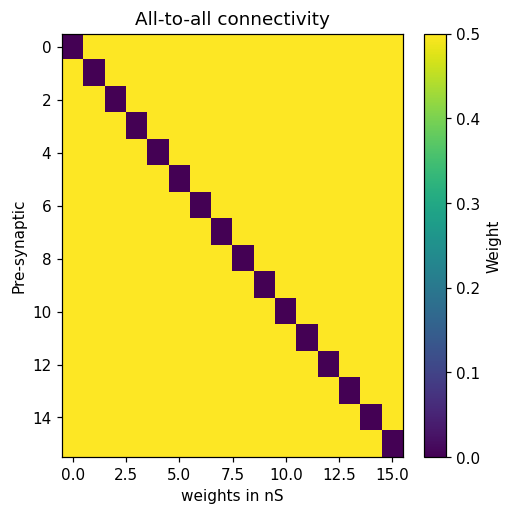

In [6]:

weights_dense, weight_unit = u.split_mantissa_unit(all_to_all_result.weight2dense())

fig, ax = plt.subplots(figsize=(5, 5))
visualize.connectivity_matrix(
    weights_dense,
    cmap="viridis",
    center_zero=False,
    ax=ax,
    title="All-to-all connectivity",
)
if weight_unit is not None:
    ax.set_xlabel(f"weights in {weight_unit}")
plt.show()



### One-to-one connectivity

One-to-one connectivity pairs each presynaptic element with exactly one
postsynaptic partner. Setting `circular=True` wraps the connections when
population sizes match.


In [7]:

one_to_one_pattern = OneToOne(
    circular=True,
    weight=Constant(0.8 * u.nS),
    delay=Constant(0.8 * u.ms),
)

one_to_one_result = one_to_one_pattern(pre_size=12, post_size=12)
summarize_result(one_to_one_result, "One-to-one connectivity (12 × 12, circular)")


One-to-one connectivity (12 × 12, circular)
  connections : 12
  shape       : 12 × 12
  density     : 0.083
  pattern     : one_to_one
  weight      : [0.800, 0.800] nS
  delay       : [0.800, 0.800] ms


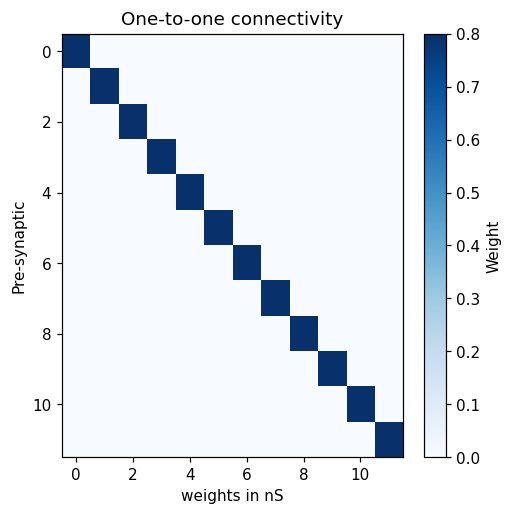

In [8]:

weights_dense, weight_unit = u.split_mantissa_unit(one_to_one_result.weight2dense())

fig, ax = plt.subplots(figsize=(5, 5))
visualize.connectivity_matrix(
    weights_dense,
    cmap="Blues",
    center_zero=False,
    ax=ax,
    title="One-to-one connectivity",
)
if weight_unit is not None:
    ax.set_xlabel(f"weights in {weight_unit}")
plt.show()



## Inspecting connection data

`ConnectionResult` exposes convenient helpers for analysis. Here we inspect
the random connectivity example to extract dense weight/delay matrices and
degree statistics.


In [9]:

weights_dense = random_result.weight2dense()
delays_dense = random_result.delay2matrix()

out_degree = np.bincount(random_result.pre_indices, minlength=random_result.shape[0])
in_degree = np.bincount(random_result.post_indices, minlength=random_result.shape[1])

print(f"Average out-degree: {out_degree.mean():.1f} ± {out_degree.std():.1f}")
print(f"Average in-degree : {in_degree.mean():.1f} ± {in_degree.std():.1f}")


Average out-degree: 12.2 ± 3.1
Average in-degree : 12.2 ± 3.3


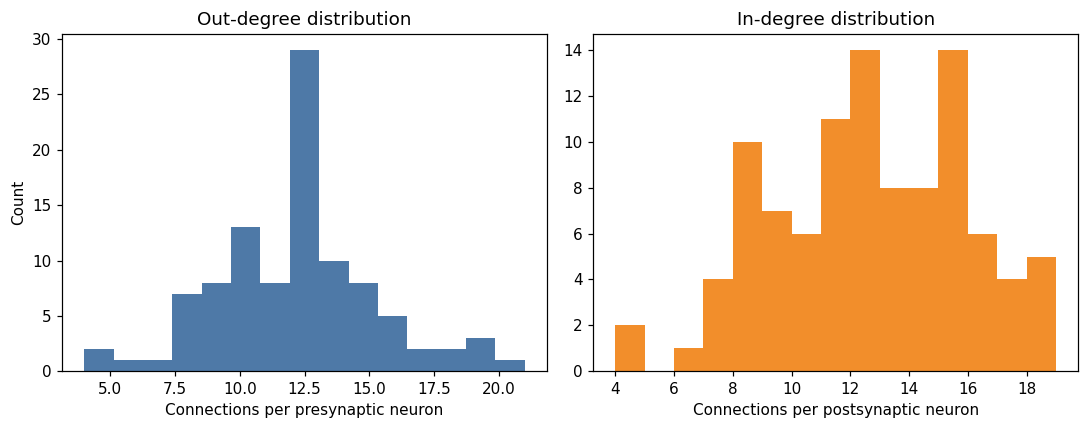

In [10]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(out_degree, bins=15, color="#4E79A7")
axes[0].set_title("Out-degree distribution")
axes[0].set_xlabel("Connections per presynaptic neuron")
axes[0].set_ylabel("Count")

axes[1].hist(in_degree, bins=15, color="#F28E2B")
axes[1].set_title("In-degree distribution")
axes[1].set_xlabel("Connections per postsynaptic neuron")

plt.tight_layout()
plt.show()



## Mini projects

The following examples combine the basic patterns into larger connectivity
setups that you can adapt for your own simulations.



### Project 1 · Large random network statistics

Build a moderately sized random network and inspect its degree histograms.
This is a quick way to sanity-check connectivity parameters before running
expensive simulations.


Random connectivity (400 × 400, p = 0.05)
  connections : 7,835
  shape       : 400 × 400
  density     : 0.049
  pattern     : random
  weight      : (implicit 1.0)
  delay       : (implicit 0.0)


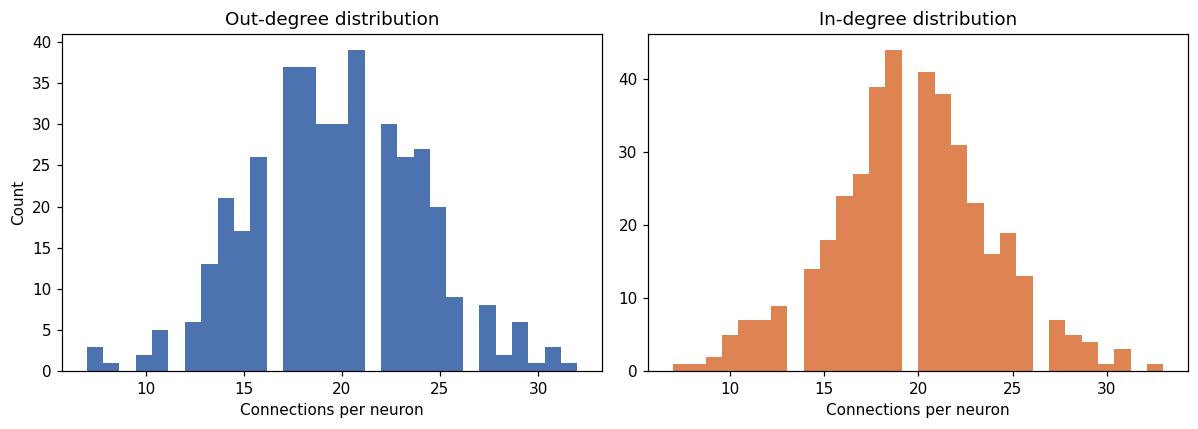

In [11]:

large_random = Random(prob=0.05, seed=7)
large_random_result = large_random(pre_size=400, post_size=400)
summarize_result(large_random_result, "Random connectivity (400 × 400, p = 0.05)")

out_degree = np.bincount(large_random_result.pre_indices, minlength=large_random_result.shape[0])
in_degree = np.bincount(large_random_result.post_indices, minlength=large_random_result.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
axes[0].hist(out_degree, bins=30, color="#4C72B0")
axes[0].set_title("Out-degree distribution")
axes[0].set_xlabel("Connections per neuron")
axes[0].set_ylabel("Count")

axes[1].hist(in_degree, bins=30, color="#DD8452")
axes[1].set_title("In-degree distribution")
axes[1].set_xlabel("Connections per neuron")

plt.tight_layout()
plt.show()



### Project 2 · Feedforward layered network

Connect three layers using random patterns with increasing mean synaptic
strengths.


Layer 0 -> 1
  connections : 1,796
  shape       : 120 × 60
  density     : 0.249
  pattern     : random
  weight      : [0.396, 1.611] nS
  delay       : [1.000, 1.000] ms
Layer 1 -> 2
  connections : 413
  shape       : 60 × 30
  density     : 0.229
  pattern     : random
  weight      : [0.674, 1.948] nS
  delay       : [1.000, 1.000] ms


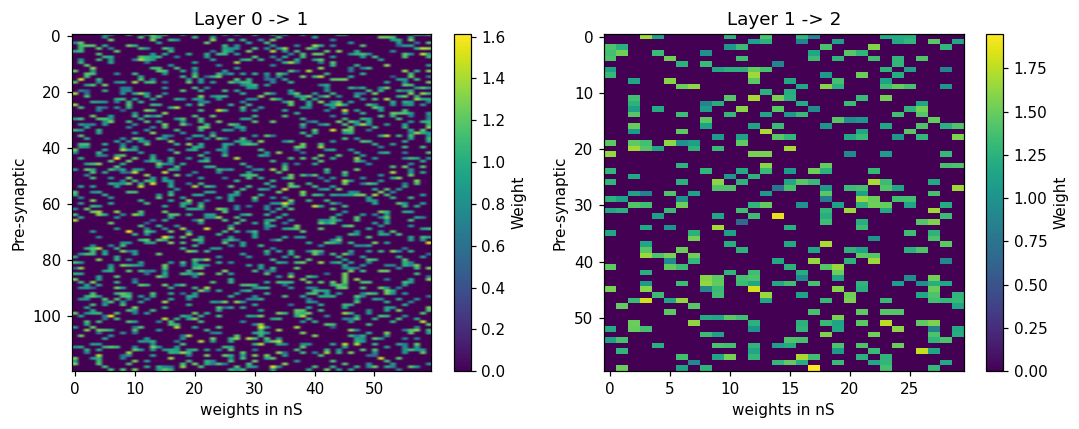

In [12]:

layer_sizes = [120, 60, 30]
layer_results = []

for idx in range(len(layer_sizes) - 1):
    pattern = Random(
        prob=0.25,
        weight=Normal(mean=(1.0 + 0.3 * idx) * u.nS, std=0.2 * u.nS),
        delay=Constant(1.0 * u.ms),
        allow_self_connections=False,
        seed=100 + idx,
    )
    result = pattern(pre_size=layer_sizes[idx], post_size=layer_sizes[idx + 1])
    layer_results.append(result)
    summarize_result(result, f"Layer {idx} -> {idx + 1}")

fig, axes = plt.subplots(1, len(layer_results), figsize=(5 * len(layer_results), 4))
for idx, (result, ax) in enumerate(zip(layer_results, np.atleast_1d(axes))):
    weights_dense, weight_unit = u.split_mantissa_unit(result.weight2dense())
    visualize.connectivity_matrix(
        weights_dense,
        cmap="viridis",
        center_zero=False,
        ax=ax,
        title=f"Layer {idx} -> {idx + 1}",
    )
    if weight_unit is not None:
        ax.set_xlabel(f"weights in {weight_unit}")
plt.tight_layout()
plt.show()



### Project 3 · Ring topology

Construct a ring topology where each neuron connects to three neighbours.


Ring topology (n = 50, neighbors = 3)
  connections : 300
  shape       : 50 × 50
  density     : 0.120
  pattern     : ring
  weight      : [1.000, 1.000] nS
  delay       : [1.000, 1.000] ms


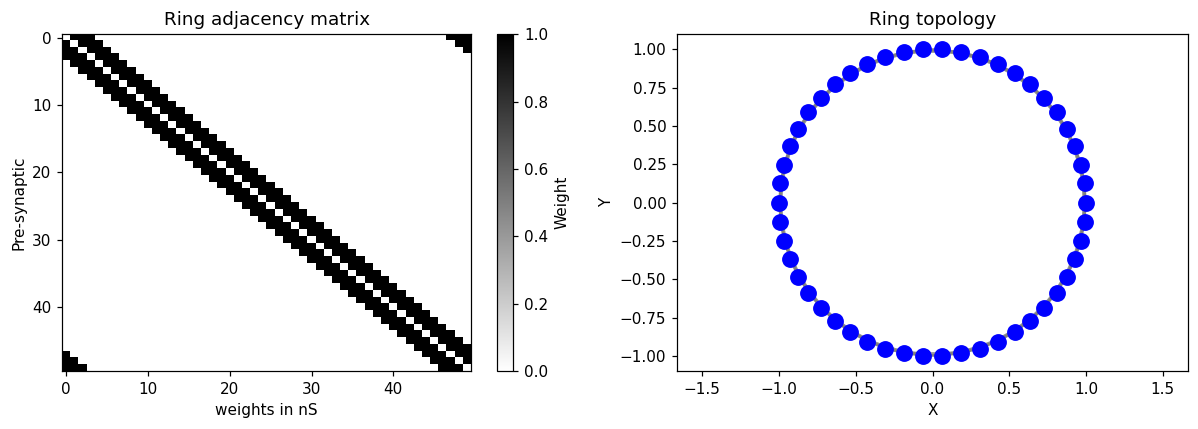

In [13]:

ring_pattern = Ring(
    neighbors=3,
    weight=Constant(1.0 * u.nS),
    delay=Constant(1.0 * u.ms),
    bidirectional=True,
)
ring_result = ring_pattern(pre_size=50, post_size=50)
summarize_result(ring_result, "Ring topology (n = 50, neighbors = 3)")

ring_dense, ring_unit = u.split_mantissa_unit(ring_result.weight2dense())

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
visualize.connectivity_matrix(
    ring_dense,
    cmap="binary",
    center_zero=False,
    ax=axes[0],
    title="Ring adjacency matrix",
)
if ring_unit is not None:
    axes[0].set_xlabel(f"weights in {ring_unit}")
visualize.network_topology(
    ring_dense,
    layout="circular",
    ax=axes[1],
    title="Ring topology",
)
plt.tight_layout()
plt.show()
